In this file, we write necessary policy components to implement a custom Recurrent Rainbow model, which implements frameworks from the following papers: 

@misc{hausknecht2017deeprecurrentqlearningpartially,
      title={Deep Recurrent Q-Learning for Partially Observable MDPs}, 
      author={Matthew Hausknecht and Peter Stone},
      year={2017},
      eprint={1507.06527},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/1507.06527}, 
}

@misc{hessel2017rainbowcombiningimprovementsdeep,
      title={Rainbow: Combining Improvements in Deep Reinforcement Learning}, 
      author={Matteo Hessel and Joseph Modayil and Hado van Hasselt and Tom Schaul and Georg Ostrovski and Will Dabney and Dan Horgan and Bilal Piot and Mohammad Azar and David Silver},
      year={2017},
      eprint={1710.02298},
      archivePrefix={arXiv},
      primaryClass={cs.AI},
      url={https://arxiv.org/abs/1710.02298}, 
}

It is important to note that Rainbow DQN and R2D2 have the following overlapping segments: 
1) Double DQN
2) Prioritized Experience Replay
3) Dueling Network
4) n-step Learning 

while Rainbow DQN also has the additional components: 
1) Categorical DQN (Distributional RL)
2) Noisy Networks

In [9]:
# importing necessary libraries
import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple, Any
import gymnasium
from gymnasium import spaces
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from segment_tree import MinSegmentTree, SumSegmentTree


Below we implement a DictReplayBuffer, that is adjusted for N-step learning. 

In [2]:
class DictReplayBufferNStep: 

    """
    A replay buffer that stores transitions (nested dictionary of NumPy arrays, since obs are returned as a dictionary) and supports N-step returns.
    """

    def __init__(
            self, 
            observation_space: spaces.Dict,
            buffer_size: int, 
            batch_size: int = 64, 
            n_step: int = 1, 
            gamma: float = 0.99,
    ): 
        
        # adding (o,a,o',r,d) to the buffer
        self.observations_buffer = {k: np.zeros([buffer_size, *v.shape], dtype=v.dtype) for k, v in observation_space.spaces.items()}                # observations
        self.next_observations_buffer = {k: np.zeros([buffer_size, *v.shape], dtype=v.dtype) for k, v in observation_space.spaces.items()}           # next observations
        self.actions_buffer = np.zeros([buffer_size], dtype=np.int64)                                                                                # actions
        self.rewards_buffer = np.zeros([buffer_size], dtype=np.float32)                                                                              # rewards
        self.dones_buffer = np.zeros([buffer_size], dtype=np.bool_)                                                                                  # dones  

        self.ptr, self.size, = 0, 0
        self.max_size, self.batch_size = buffer_size, batch_size

        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
      self, 
      obs: Dict[str, np.ndarray], 
      act: float, 
      rew: float, 
      next_obs: Dict[str, np.ndarray], 
      done: bool
    ):      
        """
        Store a new transition in the replay buffer, using N-step returns.
        """

        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

         # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]

        # store all obs keys in buffer 
        for k in obs:
            self.observations_buffer[k][self.ptr] = obs[k]
            self.next_observations_buffer[k][self.ptr] = next_obs[k]

        self.actions_buffer[self.ptr] = act
        self.rewards_buffer[self.ptr] = rew
        self.dones_buffer[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]  
    
    def sample_batch(
           self) -> Dict[str, Dict[str, np.ndarray]]:
        
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        
        return {
            'obs': {k: v[idxs] for k, v in self.observations_buffer.items()},
            'next_obs': {k: v[idxs] for k, v in self.next_observations_buffer.items()},
            'acts': self.actions_buffer[idxs],
            'rews': self.rewards_buffer[idxs],
            'done': self.dones_buffer[idxs],
            # for N-step Learning
            'indices': idxs,
        }

    def sample_batch_from_idxs(self, idxs: np.ndarray) -> Dict[str, Dict[str, np.ndarray]]:
        
        # for N-step Learning
        return {
            'obs': {k: v[idxs] for k, v in self.observations_buffer.items()},
            'next_obs': {k: v[idxs] for k, v in self.next_observations_buffer.items()},
            'acts': self.actions_buffer[idxs],
            'rews': self.rewards_buffer[idxs],
            'done': self.dones_buffer[idxs],
            }
    
    def _get_n_step_info(
            self,
            n_step_buffer: Deque,
            gamma: float,
    ) -> Tuple[float, Dict[str, np.ndarray], bool]:
        
        """
        Compute the N-step return for a given buffer of transitions.
        """

         # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]
        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]
            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)
        return rew, next_obs, done
    
    def __len__(self) -> int:
        return self.size


Below we create a Prioritized Replay Buffer which is used to implement PER. Note that we inherit from the parent DictReplayBufferNStep class.

In [3]:
class PrioritizedDictReplayBuffer(DictReplayBufferNStep):

    """
    A prioritized replay buffer that stores transitions (with the observation being a dictionary) and supports N-step returns.

    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
    """

    def __init__(
            self, 
            observation_space: spaces.Dict,
            buffer_size: int, 
            batch_size: int = 64, 
            alpha: float = 0.6,
            n_step: int = 1, 
            gamma: float = 0.99,
    ):
        
        assert alpha >= 0

        super().__init__(observation_space, buffer_size, batch_size, n_step, gamma)
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(
      self, 
      obs: Dict[str, np.ndarray], 
      act: float, 
      rew: float, 
      next_obs: Dict[str, np.ndarray], 
      done: bool
    ):      
        
        """Store experience and its priority."""

        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        
        return transition

    def sample_batch(
            self, 
            beta: float = 0.4, 
        ) -> Dict[str, np.ndarray]: 

        assert len(self) >= self.batch_size
        assert beta > 0

        indices = self._sample_proportional()

        return {
            'obs': {k: self.observations_buffer[k][indices] for k in self.observations_buffer.keys()},
            'next_obs': {k: self.next_observations_buffer[k][indices] for k in self.next_observations_buffer.keys()},
            'acts': self.actions_buffer[indices],
            'rews': self.rewards_buffer[indices],
            'done': self.dones_buffer[indices],
            # for N-step Learning and PER
            'indices': indices,
            'weights': np.array([self._calculate_weight(i, beta) for i in indices], dtype=np.float32)

        }
    
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight


We now implement noisy layers for exploration, which is used to modify the standard MLP for predicting Q-values, to an MLP with noisy layers. 

In [4]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    
        
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        std_init: float = 0.5, # initial std value, determines how noisy our network is
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

To finish implementing a Rainbow DQN, we need to implement a noisy net (NoisyLinear is employed for the last two layers of advantage and value layers), introduce a dueling architecture for the DQN heads (which, explicitly separates the representation of state values and (state-dependent) action advantage), and learn the distribution of returns with a categorical strategy. 

In [6]:
"""
Implements the Rainbow DQN network architecture that integrates:
- Custom feature extraction (via CustomFeatureExtractor for dict observations)
- Noisy linear layers for exploration
- Dueling network architecture
- Distributional RL (C51-style categorical distribution)

The CustomFeatureExtractor processes our specific observation space before feeding them into the noisy dueling head.
"""

from CustomFeatureExtractor import CustomFeatureExtractor


class Network(nn.Module):
    def __init__(
        self, 
        feature_extractor: nn.Module, 
        out_dim: int, 
        atom_size: int, 
        support: torch.Tensor
    ):
        
        """
        Args:
            feature_extractor (nn.Module): Predefined feature extractor module
                (which for us is the CustomFeatureExtractor) that converts dict observations into a flat feature tensor. Different keys will get passed
                through different layers as defined in the CustomFeatureExtractor.
            out_dim (int): Number of discrete actions.
            atom_size (int): Number of atoms for distributional RL (C51).
            support (torch.Tensor): The discrete support (value atoms).
        """

        super(Network, self).__init__()
        
        self.feature_extractor = feature_extractor
        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        in_dim = feature_extractor._features_dim # output dim of feature extractor 
        
        hidden_dim = 512

        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(in_dim, hidden_dim)
        self.advantage_layer = NoisyLinear(hidden_dim, out_dim * atom_size)

        # set value layer
        self.value_hidden_layer = NoisyLinear(in_dim, hidden_dim)
        self.value_layer = NoisyLinear(hidden_dim, atom_size)

    def forward(self, obs: dict) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(obs)
        q = torch.sum(dist * self.support, dim=2)
        
        return q
    
    def dist(self, obs: dict) -> torch.Tensor:
        """Get distribution for atoms."""

        feature = self.feature_extractor(obs)

        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))
        
        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans
        
        return dist
    
    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

We now implement the Rainbow DQN agent class with the following methods: 
    1) select_action:	select an action from the input state.
    2) step:	take an action and return the response of the env.
    3) compute_dqn_loss:	return dqn loss.
    4) update_model:	update the model by gradient descent.
    5) target_hard_update:	hard update from the local model to the target model.
    6) train:	train the agent for an amount of timesteps
    7) test:	test the agent (1 episode).
    8) plot: plot the training progresses.

In [10]:
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

class DQNAgent:
    """
    DQN Agent interacting with environment.

    Modified to:
    1. Handle dictionary observations.
    2. Log training data to TensorBoard.
    3. Save the final model as a .zip file (SB3-style).
    
    Attribute:
        env:: gymnasium.Env (new gymnasium version)
        memory (PrioritizedDictReplayBuffer): replay memory to store transitions, with our observation being a dictionary
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           observation, action, reward, next_observation, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (DictReplayBufferNStep): n-step replay buffer with dict observations 
    """

    def __init__(
        self, 
        env: gymnasium.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        seed: int,
        gamma: float = 0.99,
        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
        lr: float = 1e-4,
    ):
        
        action_dim = env.action_space.n
        
        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.seed = seed
        self.gamma = gamma

        # NoisyNet: All attributes related to epsilon are removed
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(f"Using device: {self.device}")
            
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps

        self.memory = PrioritizedDictReplayBuffer(
            observation_space=self.env.observation_space,
            buffer_size=memory_size,
            batch_size=batch_size,
            alpha=alpha,
            gamma=gamma,
            n_step=1,      
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = DictReplayBufferNStep(
                observation_space=self.env.observation_space,
                buffer_size=memory_size,
                batch_size=batch_size,
                n_step=n_step,
                gamma=gamma
            )
            
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            CustomFeatureExtractor(self.env.observation_space), 
            action_dim, 
            self.atom_size, 
            self.support
        ).to(self.device)

        self.dqn_target = Network(
            CustomFeatureExtractor(self.env.observation_space), 
            action_dim, 
            self.atom_size, 
            self.support
        ).to(self.device)

        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr)

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def _dict_obs_to_tensor(self, obs: Dict[str, np.ndarray]) -> Dict[str, torch.Tensor]:
        """Helper: Convert a single observation dict to a batched tensor dict."""
        tensor_obs = {}
        for key, value in obs.items():
            tensor_obs[key] = torch.as_tensor(value).unsqueeze(0).to(self.device)
        return tensor_obs
    
    def _dict_batch_to_tensor(self, obs_batch: Dict[str, np.ndarray]) -> Dict[str, torch.Tensor]:
        """Helper: Convert a batch observation dict to a tensor dict."""
        tensor_obs = {}
        for key, value in obs_batch.items():
            tensor_obs[key] = torch.as_tensor(value).to(self.device)
        return tensor_obs

    def select_action(self, state: np.ndarray) -> np.ndarray:

        """Select an action from the input state."""
        state_tensor = self._dict_obs_to_tensor(state)

        # NoisyNet: no epsilon greedy action selection
        selected_action = self.dqn(state_tensor).argmax()
        selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:

        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
        
    def train(self, timesteps: int, plotting_interval: int = 100):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        losses = []
        scores = []
        score = 0

        for step in range(1, timesteps + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            
            # NoisyNet: removed decrease of epsilon
            
            # PER: increase beta
            fraction = min(step / timesteps, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if step % plotting_interval == 0:
                self._plot(scores, losses)
                
        self.env.close()
                
    def _compute_dqn_loss(self, samples: Dict[str, Any], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss, adapted for Dict samples."""
        device = self.device
        
        # Convert dictionary observations to tensors
        state = self._dict_batch_to_tensor(samples["obs"])
        next_state = self._dict_batch_to_tensor(samples["next_obs"])
        
        # Convert other samples to tensors
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            # Fix edge cases where l == u
            l[(u > 0) & (l == u)] -= 1
            u[(l < (self.atom_size - 1)) & (l == u)] += 1

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        
        # Clamp proj_dist to avoid log(0) = -inf -> nan
        proj_dist = proj_dist.clamp(min=1e-3)
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self,  
        scores: List[float], 
        losses: List[float],
        window_size: int = 100 # Window for rolling mean
    ):
        """Plot the training progresses: Episode Mean Reward and Loss."""
        clear_output(True)
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Mean Episode Reward
        plt.subplot(121)
        
        # Calculate rolling mean
        if len(scores) > window_size:
            rolling_mean = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
            plt.plot(rolling_mean, label=f'Rolling Mean ({window_size} episodes)')
        else:
            plt.plot(scores, label='Episode Return')
            
        mean_rew = np.mean(scores[-window_size:]) if len(scores) >= window_size else np.mean(scores)
        plt.title(f'Mean Return: {mean_rew:.2f}')
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.legend()

        # Plot 2: Loss
        plt.subplot(122)
        plt.title('Loss')
        
        # Also plot a rolling mean for loss
        if len(losses) > window_size:
            loss_mean = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
            plt.plot(loss_mean)
        else:
            plt.plot(losses)
            
        plt.xlabel('Update Step')
        plt.ylabel('Loss')
        
        plt.tight_layout()
        plt.show()

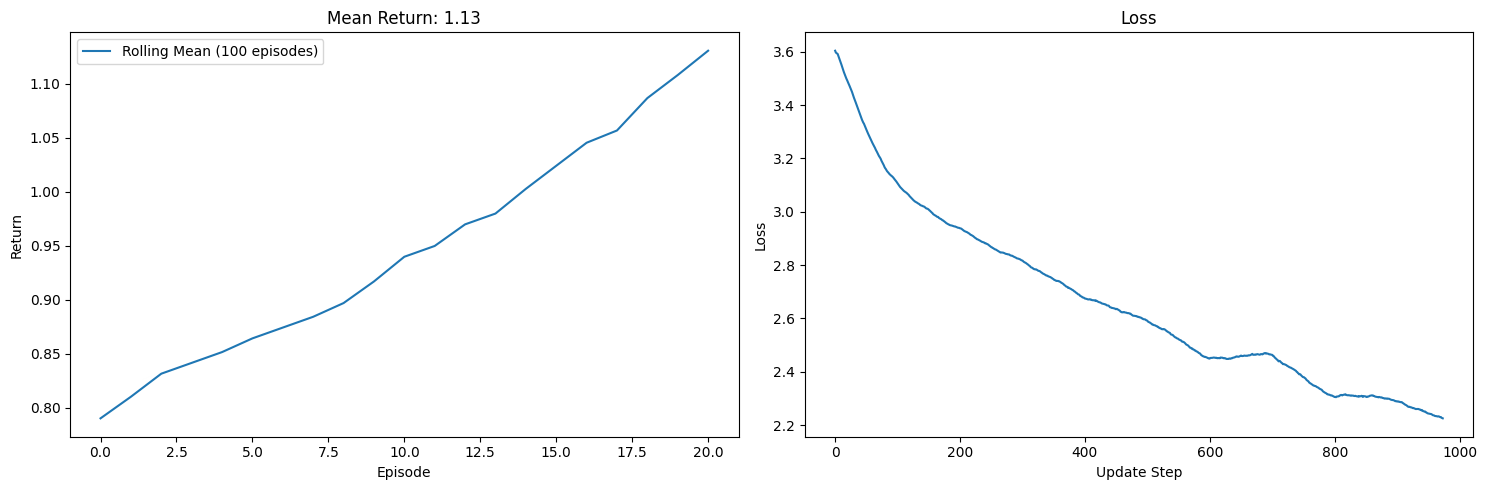

KeyboardInterrupt: 

In [11]:
from Env import VoltageDistributionEnv

env = VoltageDistributionEnv()
agent = DQNAgent(
    env=env,
    memory_size=100_000,        # stores how many (o,a,o',r,d) transitions are stored in replay buffer 
    batch_size=128,             # batch size for sampling transitions from replay buffer
    target_update=100,          # target network update frequency (hard update)
    gamma=0.99,                 # discount factor

    alpha=0.1,                  # PER hyperparameter alpha, controls prioritization of high-error transitions
    beta=0.8,                   # PER hyperparameter beta, controls amount of importance-sampling correction
    prior_eps=1e-4,             # PER hyperparameter prior_eps, small value to ensure every transition can be sampled

    seed=1,                     # random starting seed for weights and biases 
    v_min=0.0,                  # minimal support (return) value for categorical DQN
    v_max=10.1,                 # maximal support (return) value for categorical DQN
    atom_size=51,               # number of discrete atoms in categorical DQN
    n_step=1,                   # how many n steps to look ahead for N-step learning
    lr=2.5e-4,                  # learning rate for optimizer
)

""" NOTE: The noise for the NoisyNet layers is defined within the noisylayer class above."""

agent.train(timesteps=10_000, plotting_interval=100)